# 0.3 Station Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_Trips = pd.read_csv('boston_2017.csv')
df_stations_2017 = pd.read_csv('previous_Hubway_Stations_as_of_July_2017.csv')

In [ ]:
df_stations_2017.info()

In [ ]:
station_location = df_stations_2017[['Station','Latitude','Longitude']]
start_station_location = station_location.rename(columns={"Station": "start_station_name", "Latitude": "start_latitude",  "Longitude": "start_longitude"})
end_station_location = station_location.rename(columns={"Station": "end_station_name", "Latitude": "end_latitude",  "Longitude": "end_longitude"})

end_station_location

In [ ]:
df_Trips2 = df_Trips.merge(start_station_location, left_on ='start_station_name', right_on='start_station_name', how ='left')
df_Trips3 = df_Trips2.merge(end_station_location, left_on ='end_station_name', right_on='end_station_name', how = 'left')

df_Trips3


In [ ]:
print("Trip 2 contains %d missing values" % df_Trips2.isnull().values.sum())

print("Trip 3 contains %d missing values" % df_Trips3.isnull().values.sum())

In [ ]:
df_Trips3.info()

In [ ]:
#sns.kdeplot(data=df_Trips3,
#            x='start_longitude', 
#            y='start_latitude', 
#            fill=True,
#            cmap='coolwarm',
#            alpha=0.3, 
#            gridsize=200,
#            levels=20)
            #,
            #ax=ax)

/Users/hannesvogelsang/opt/anaconda3/envs/GeoJu/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/GeoJu/lib/python3.10/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/hannesvogelsang/opt/anaconda3/envs/GeoJu/lib/python3.10/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/hannesvogelsang/opt/anaconda3/

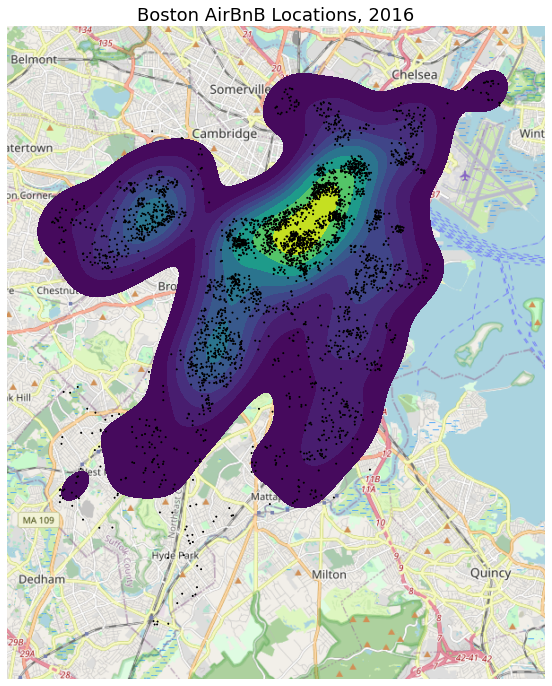

In [4]:
boston_airbnb_listings = gpd.read_file(gplt.datasets.get_path('boston_airbnb_listings'))

ax = gplt.kdeplot(
    boston_airbnb_listings, cmap='viridis', projection=gcrs.WebMercator(), figsize=(12, 12),
    shade=True
)
gplt.pointplot(boston_airbnb_listings, s=1, color='black', ax=ax)
gplt.webmap(boston_airbnb_listings, ax=ax)
plt.title('Boston AirBnB Locations, 2016', fontsize=18)

fig = plt.gcf()
plt.savefig("boston-airbnb-kde.png", bbox_inches='tight', pad_inches=0.1)